In [1]:
%matplotlib widget

import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from ProcessResults import *
from DatasetTester import *
from GetLandmarks_og import GetLandmarks 
#from LandmarkTester_alt import LandmarkTester

from landmark_utils import vis_landmarks, compare_landmarks
from vis_utils import *


import cv2
import numpy as np
import time
import timeit
from pathlib import Path
import csv
import pickle

from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler, PowerTransformer, QuantileTransformer
import xgboost as xgb
from scipy import linalg
import seaborn as sns

In [2]:
MEEI_path = Path('./MEEI_Standard_Set')
pat_info = pd.read_excel(MEEI_path/"pat_info.xlsx", sheet_name='Sheet1')

In [3]:
pat_info = pd.read_pickle('MEEI_pat_info.pkl')

with open('all_pats_processed_data.pickle','rb') as f:
    loaded_pats = pickle.load(f)

In [4]:
pat_info

,Category,Sub-category,#,Side,Gender,Age,Path,HB_scale
0,Flaccid,Complete,1,Left,Male,54,MEEI_Standard_Set/Flaccid/CompleteFlaccid/Comp...,6
1,Flaccid,Complete,2,Right,Female,16,MEEI_Standard_Set/Flaccid/CompleteFlaccid/Comp...,6
2,Flaccid,Complete,3,Right,Male,38,MEEI_Standard_Set/Flaccid/CompleteFlaccid/Comp...,6
3,Flaccid,Complete,4,Left,Female,31,MEEI_Standard_Set/Flaccid/CompleteFlaccid/Comp...,6
4,Flaccid,Complete,5,Left,Female,52,MEEI_Standard_Set/Flaccid/CompleteFlaccid/Comp...,6
5,Flaccid,Mild,1,Left,Male,72,MEEI_Standard_Set/Flaccid/MildFlaccid/MildFlac...,3
6,Flaccid,Mild,2,Right,Female,55,MEEI_Standard_Set/Flaccid/MildFlaccid/MildFlac...,3
7,Flaccid,Mild,3,Left,Male,75,MEEI_Standard_Set/Flaccid/MildFlaccid/MildFlac...,3
8,Flaccid,Moderate,1,Left,Male,51,MEEI_Standard_Set/Flaccid/ModerateFlaccid/Mode...,4
9,Flaccid,Moderate,3,Left,Female,62,MEEI_Standard_Set/Flaccid/ModerateFlaccid/Mode...,4


In [5]:
# x - choose one
all_ids = loaded_pats[0]
all_imgs = loaded_pats[1]
all_lms = loaded_pats[2]
all_features = loaded_pats[3]

# y
all_hb = loaded_pats[4]

In [6]:
# Find NaN and Inf values
bad_indices = np.where(np.isnan(all_features).sum(axis=1) > 0)[0]
bad_indices = np.append(bad_indices, np.where(np.isinf(all_features).sum(axis=1) > 0)[0])
bad_indices.sort()
bad_indices

array([], dtype=int64)

In [7]:
# drop bad indices 
# x
all_ids = np.delete(all_ids, bad_indices, axis=0)
all_imgs = np.delete(all_imgs, bad_indices, axis=0)
all_lms = np.delete(all_lms, bad_indices, axis=0)
all_features = np.delete(all_features, bad_indices, axis=0)

# y
all_hb = np.delete(all_hb, bad_indices, axis=0)

all_features.shape, all_hb.shape

((408, 29), (408,))

In [8]:
plot_df = pd.DataFrame(all_features, columns = ['f'+str(i) for i in range(0, 29)])

In [9]:
plot_df['hb'] = all_hb

In [10]:
def feature_plot(df, which_feature, group_by):
    sns.displot(df, x=which_feature, hue=group_by, element="step")
    

/opt/anaconda/envs/bp/lib/python3.10/site-packages/seaborn/axisgrid.py:447: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure(figsize=figsize)


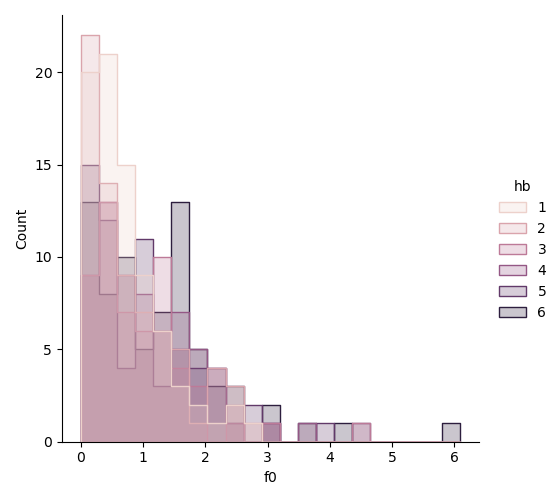

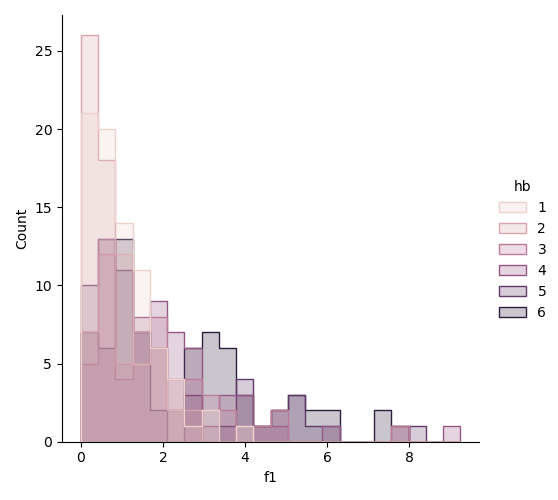

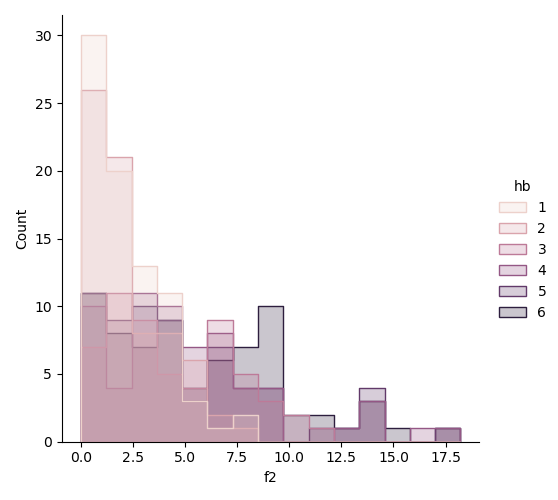

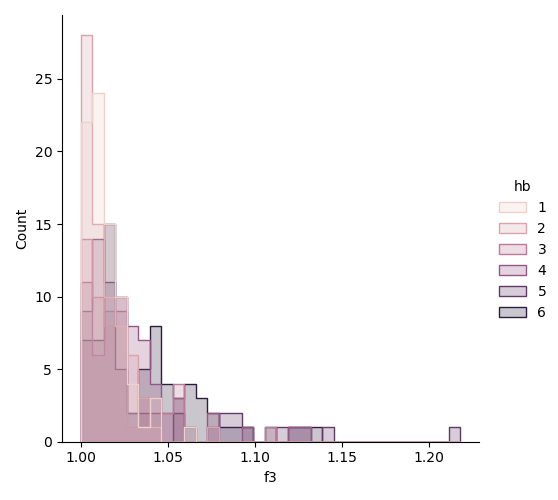

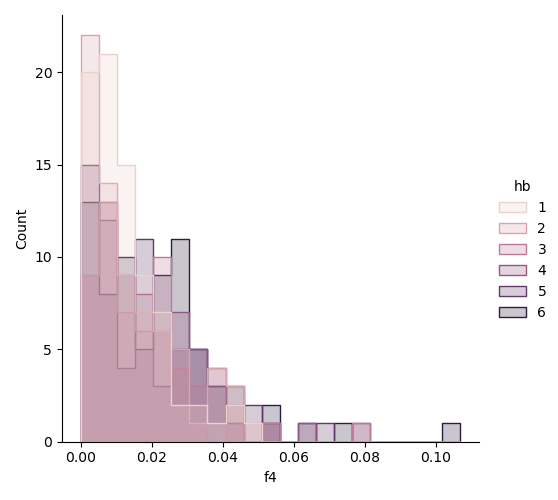

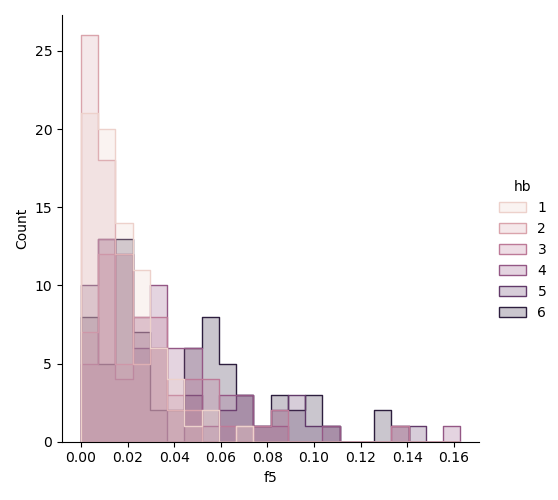

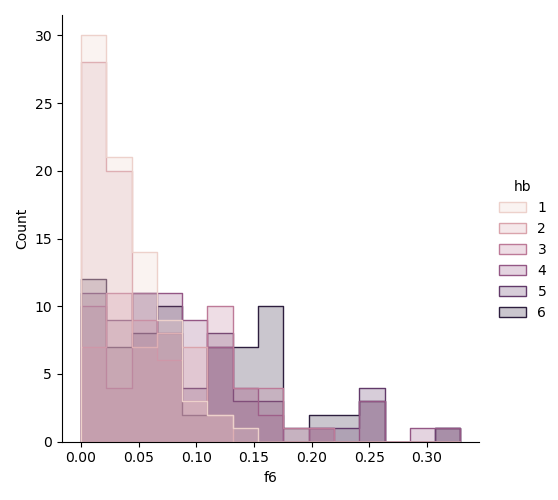

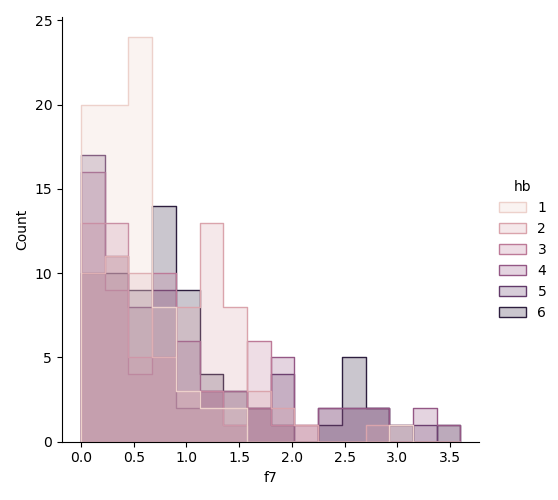

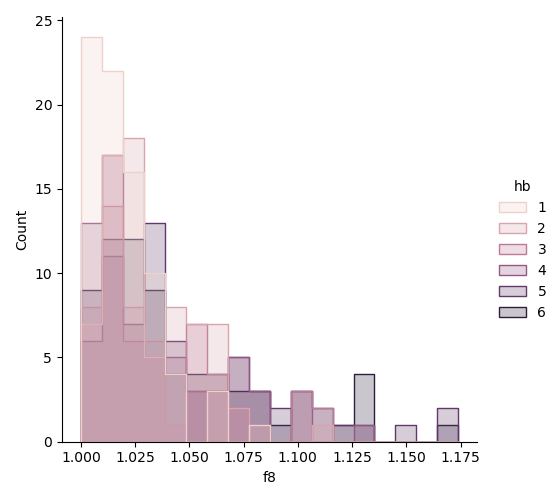

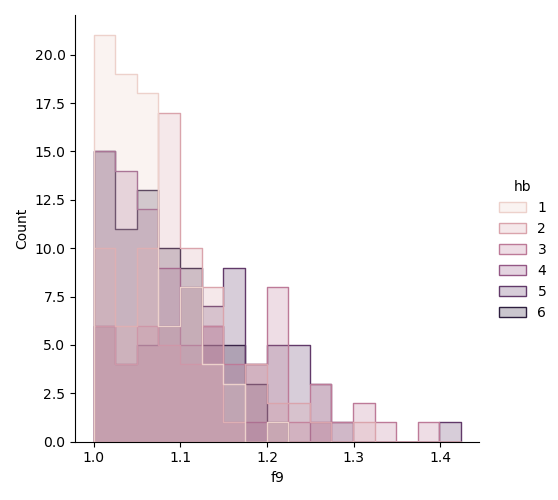

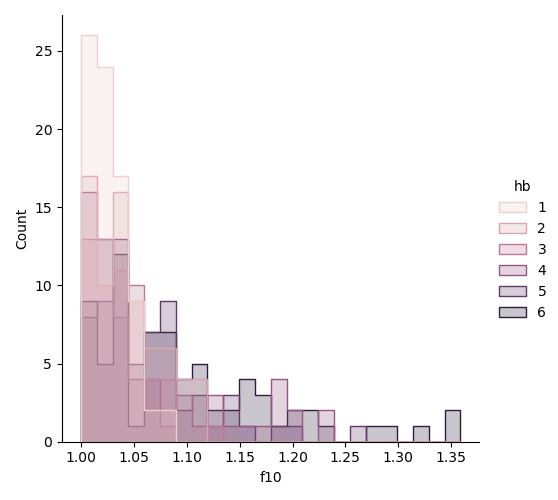

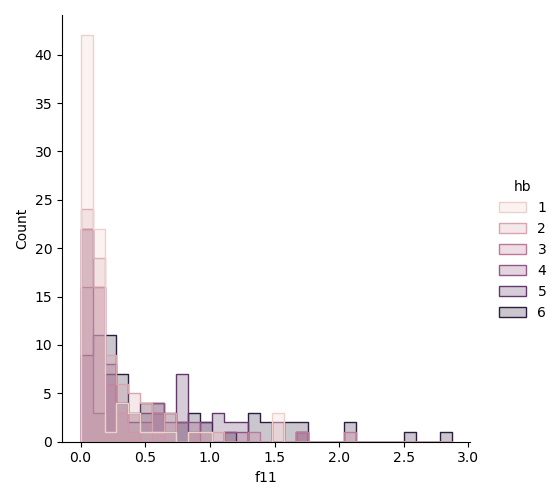

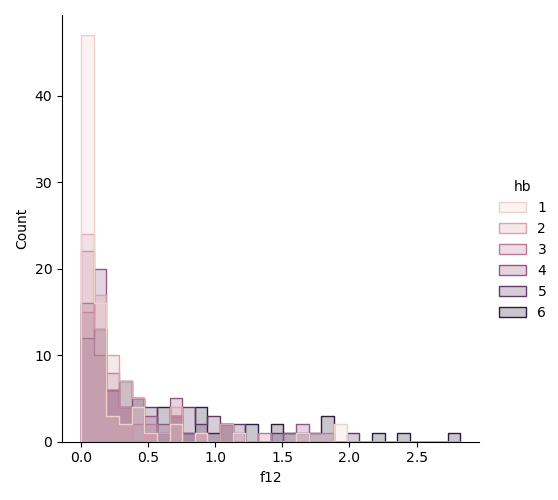

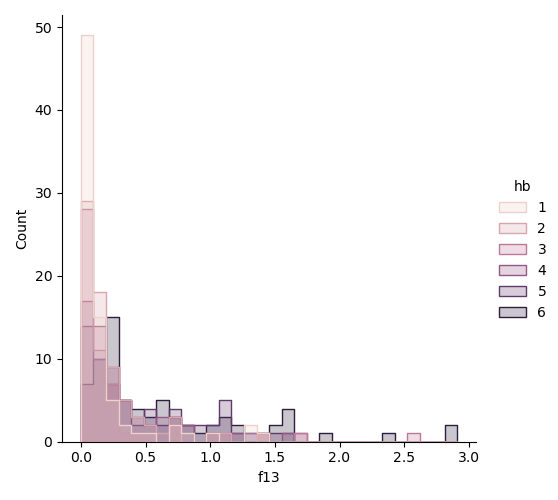

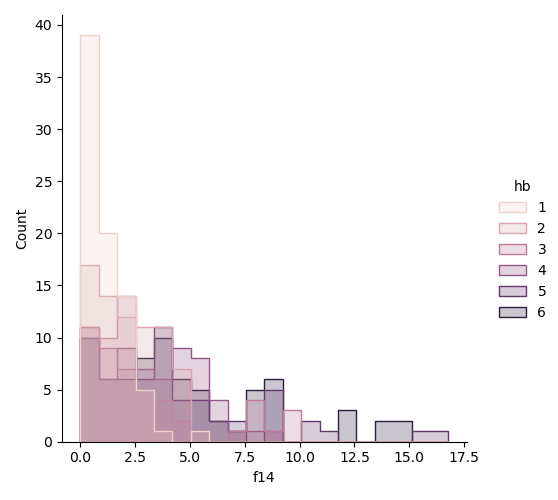

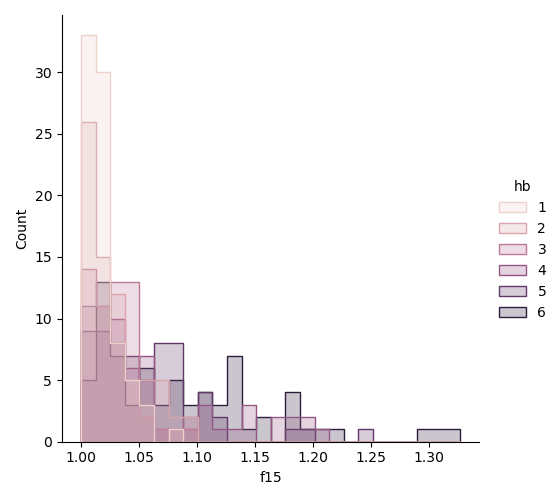

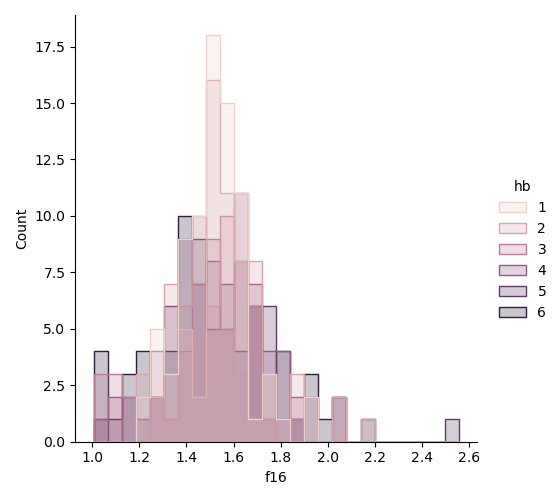

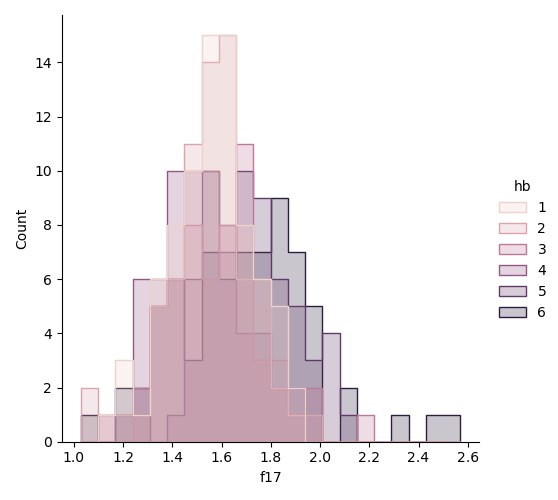

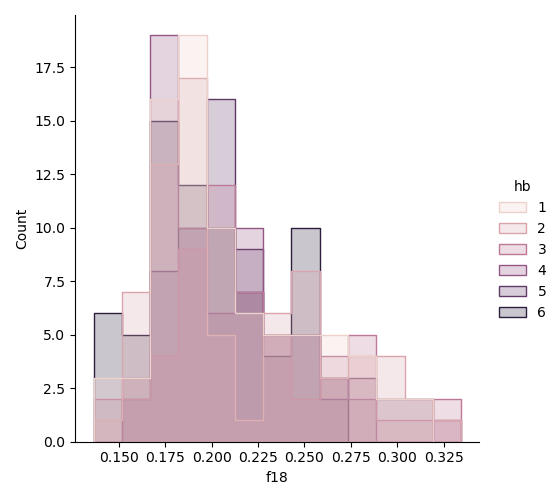

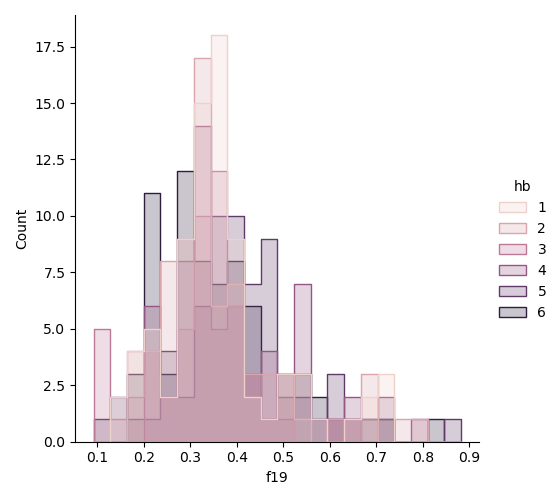

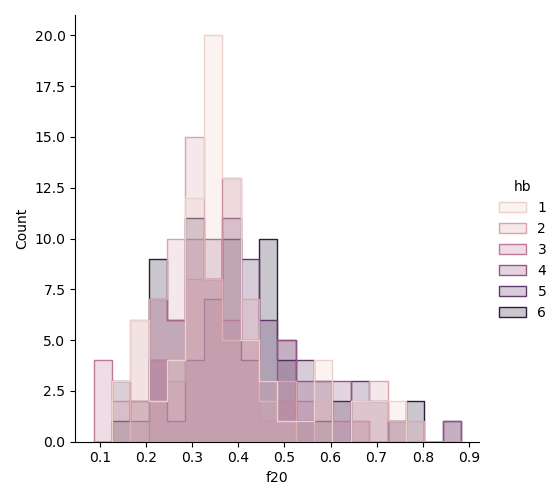

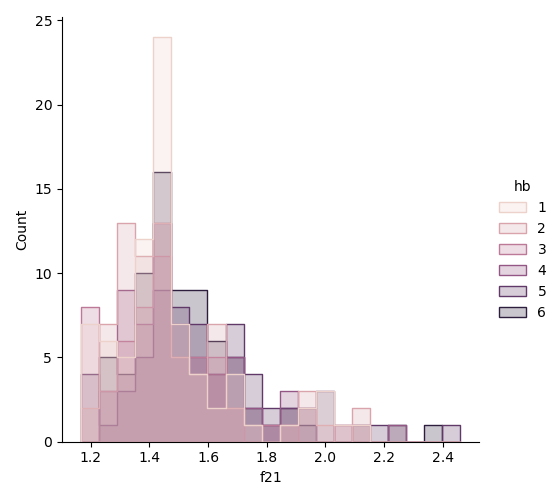

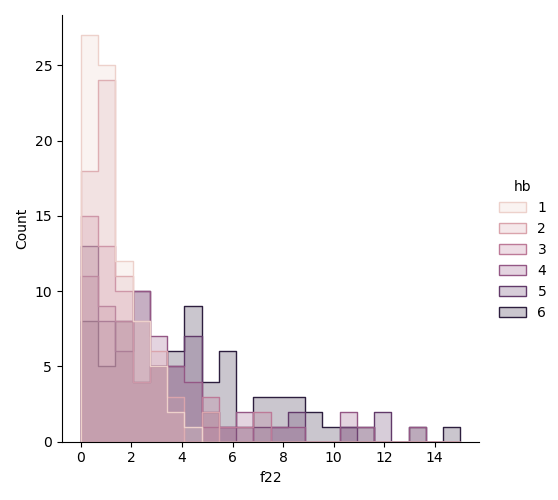

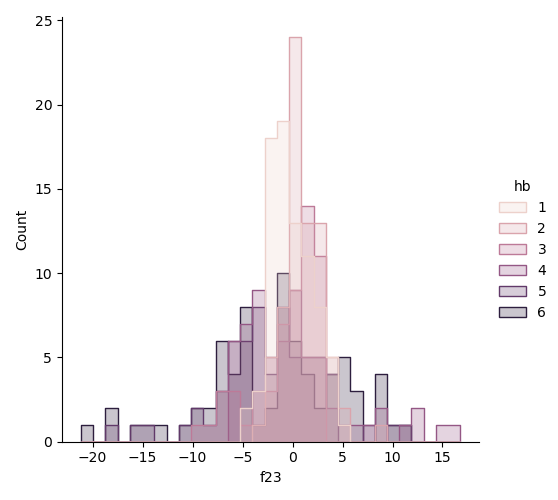

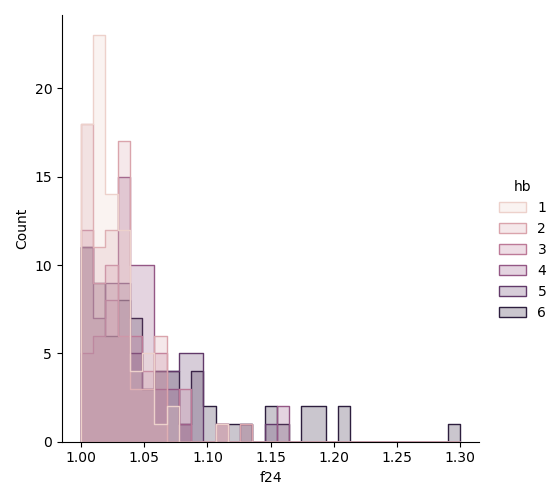

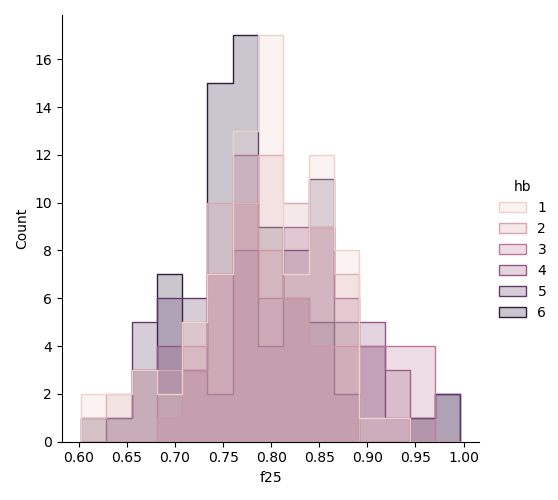

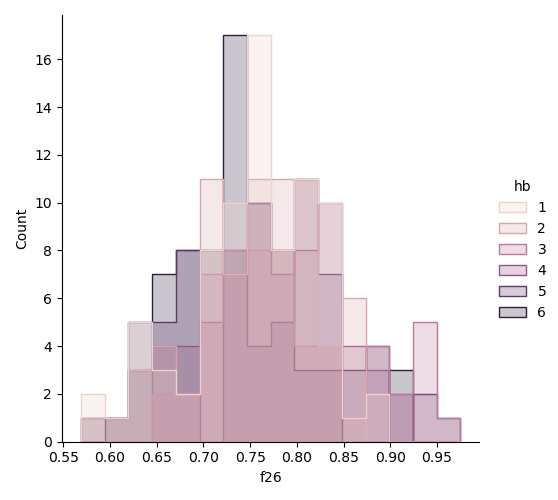

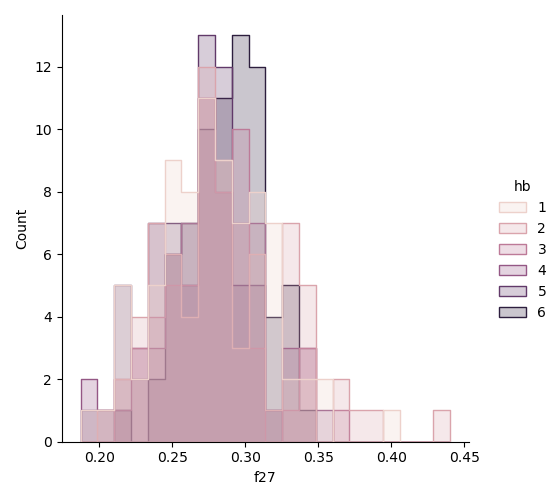

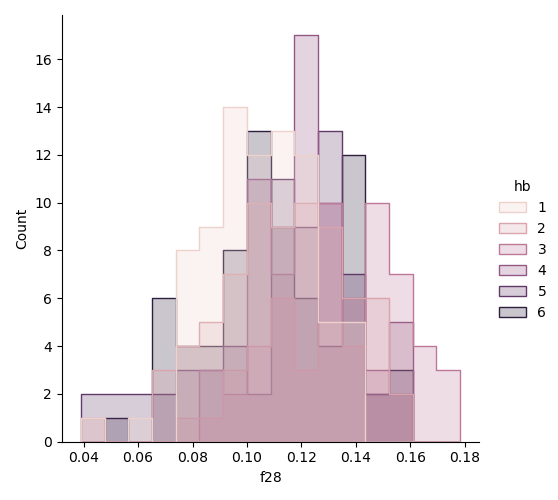

In [11]:
for i in range(0, 29):
    feature_plot(plot_df, 'f'+str(i), 'hb')

### Now try transformations on the data

In [15]:
#scaler = StandardScaler() # standardize features by removing the mean and scaling to unit variance
#scaler = MinMaxScaler() # scale features to lie between 0 and 1
#scaler = PowerTransformer(method='box-cox') # apply a power transform featurewise to make data more Gaussian-like
scaler = QuantileTransformer(output_distribution='normal') # transform features using quantiles information

all_features_scaled = scaler.fit_transform(all_features)

/opt/anaconda/envs/bp/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:2583: UserWarning: n_quantiles (1000) is greater than the total number of samples (408). n_quantiles is set to n_samples.
  warnings.warn(


In [16]:
plot_df_scaled = pd.DataFrame(all_features_scaled, columns = ['f'+str(i) for i in range(0, 29)])
plot_df_scaled['hb'] = all_hb

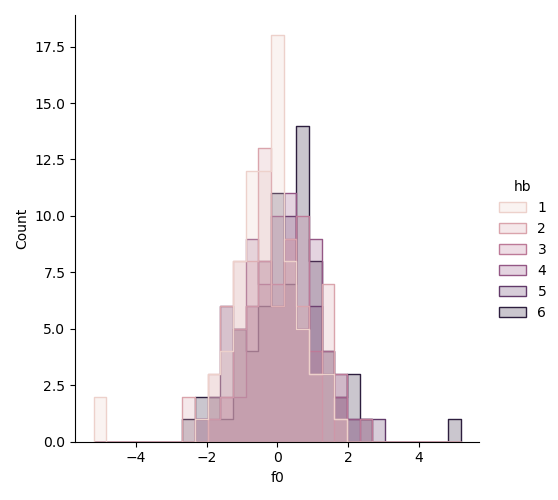

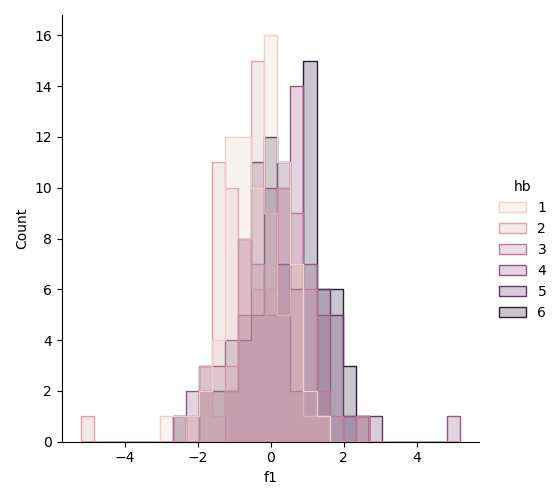

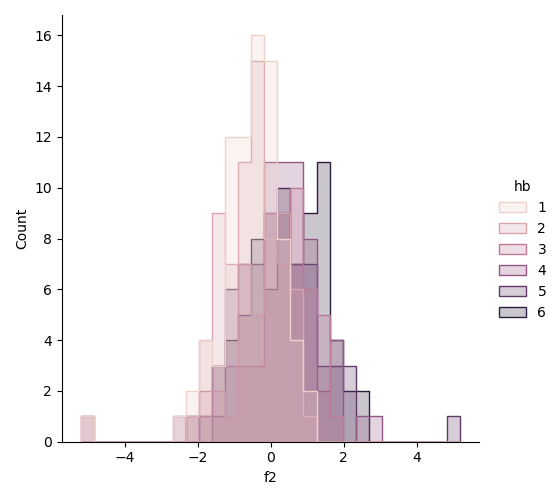

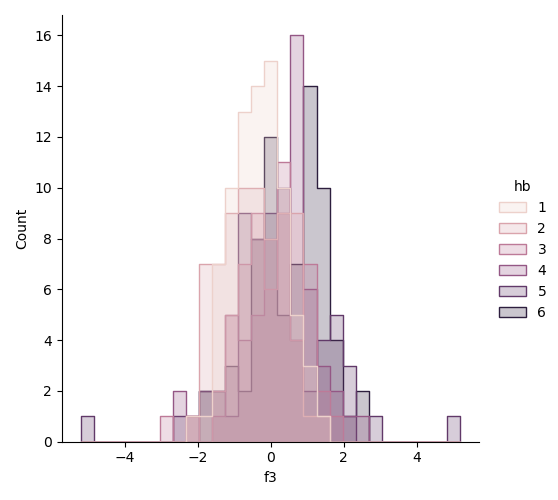

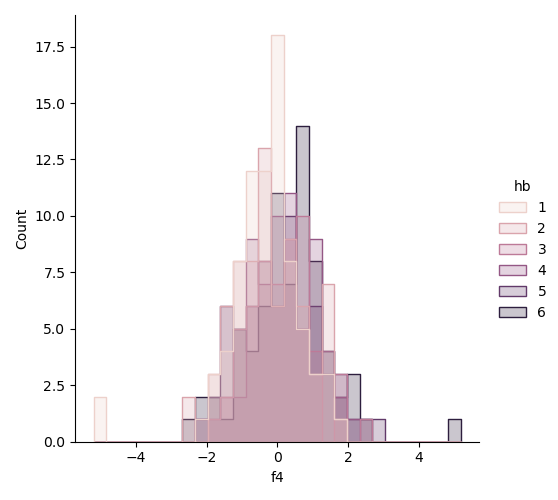

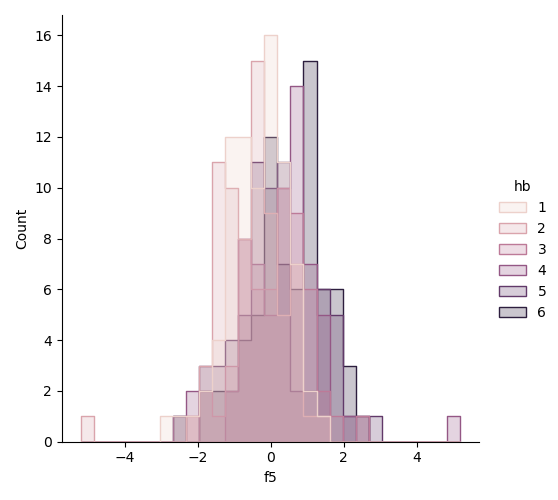

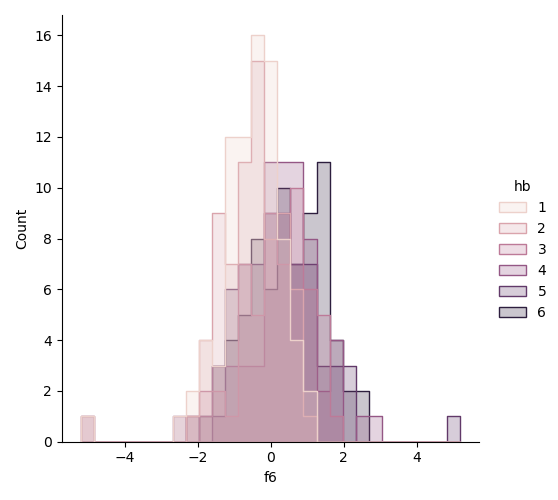

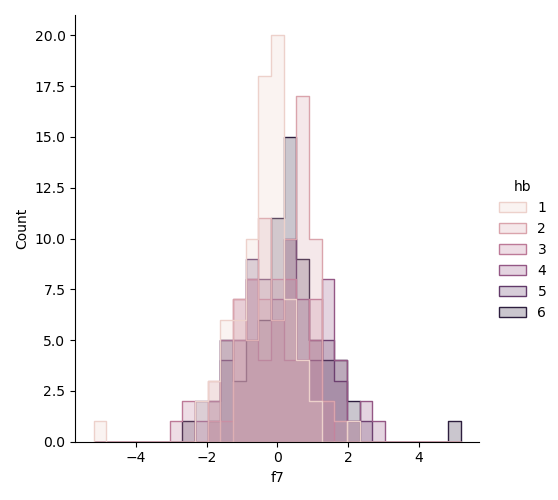

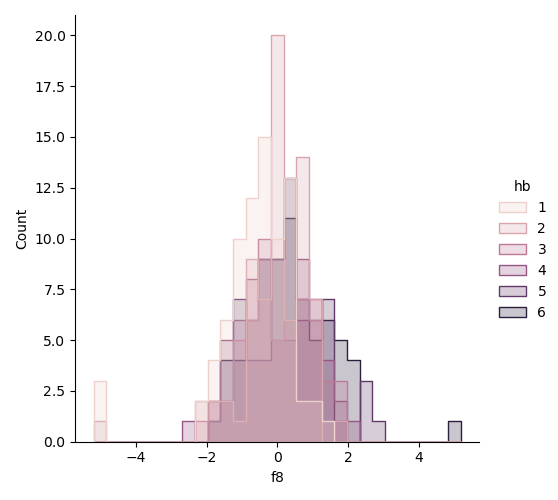

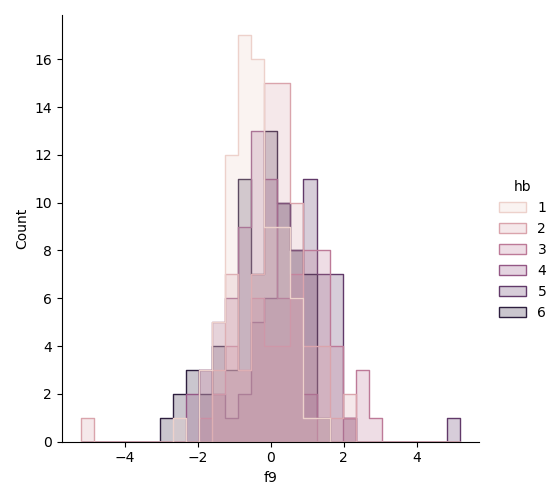

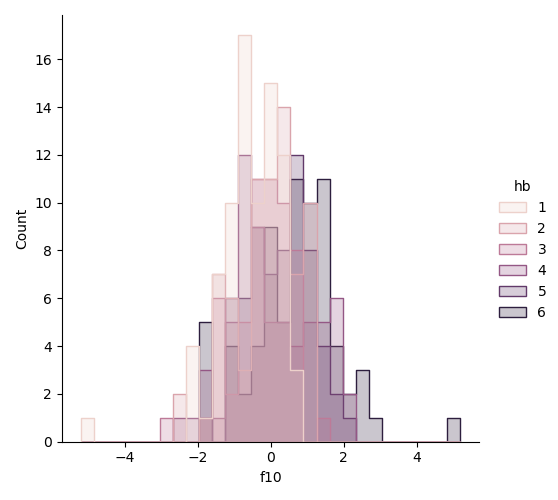

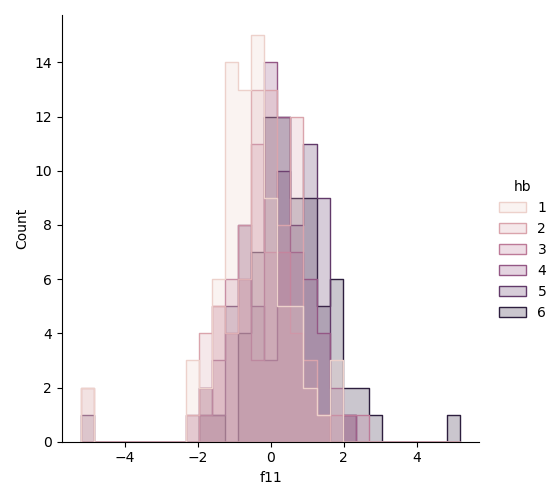

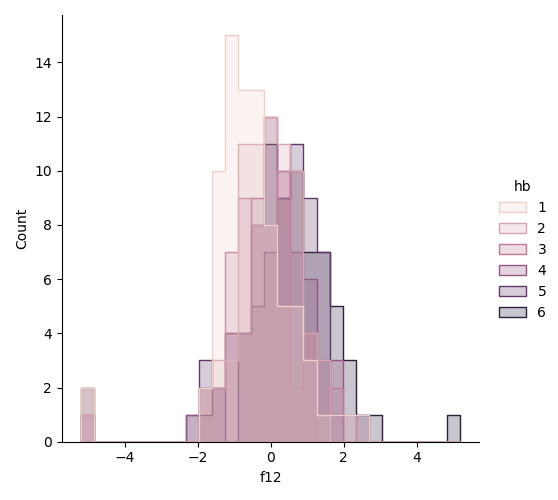

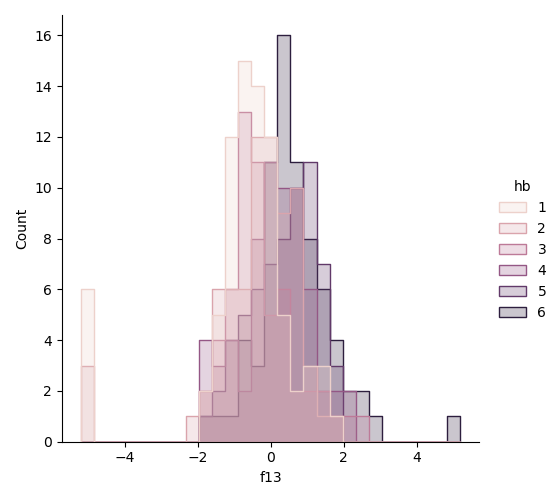

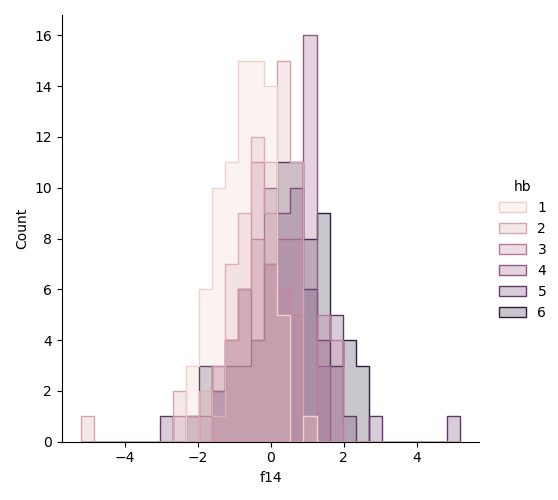

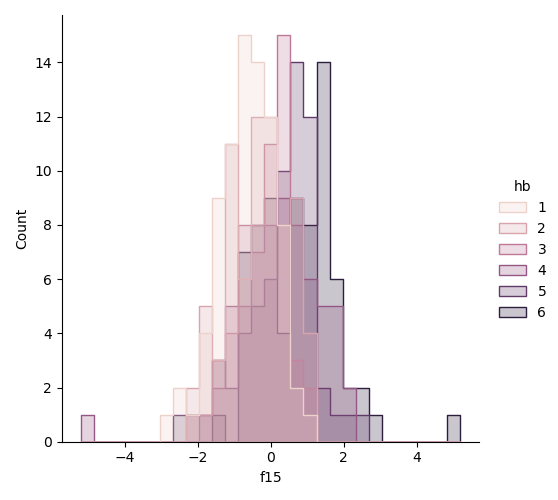

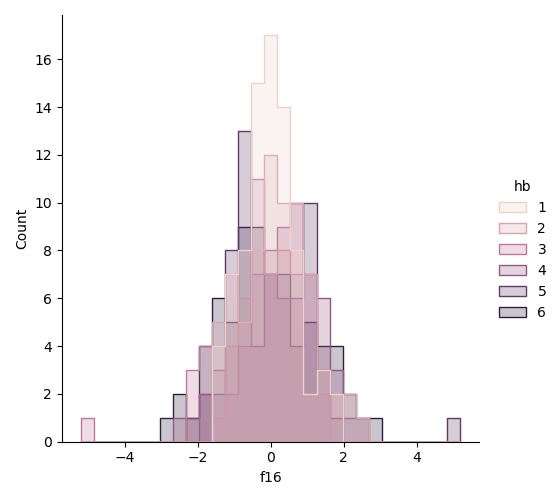

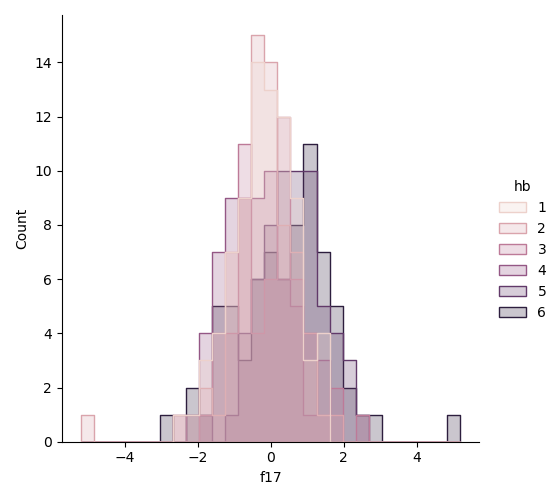

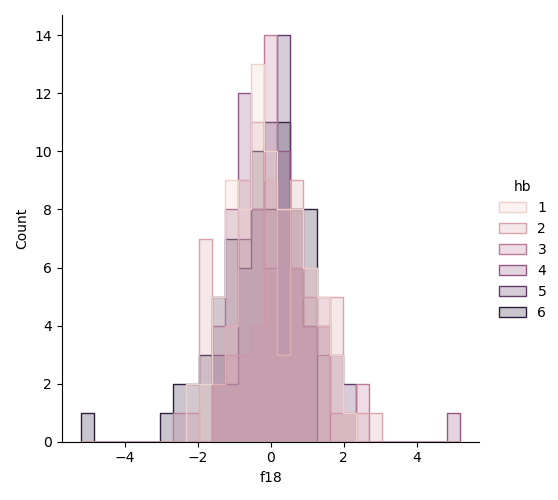

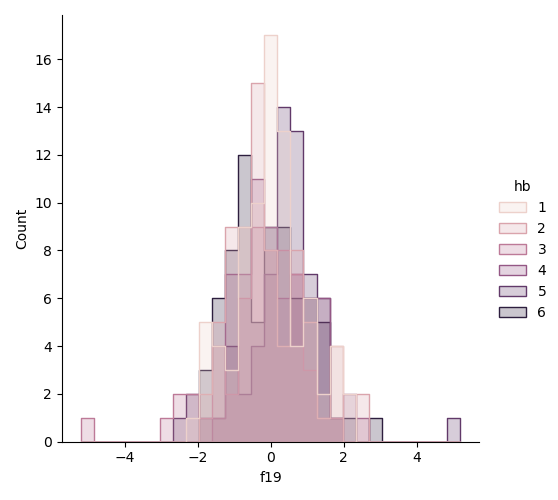

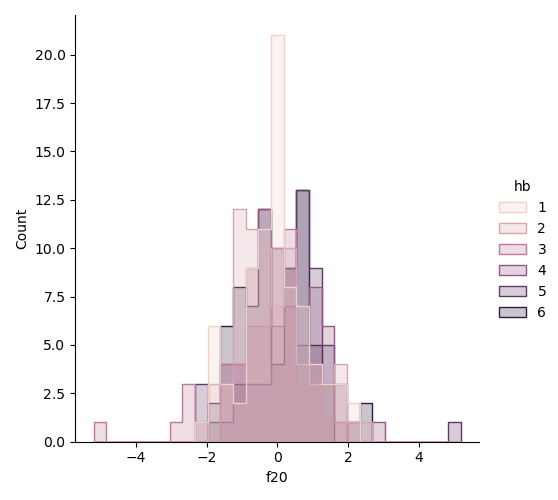

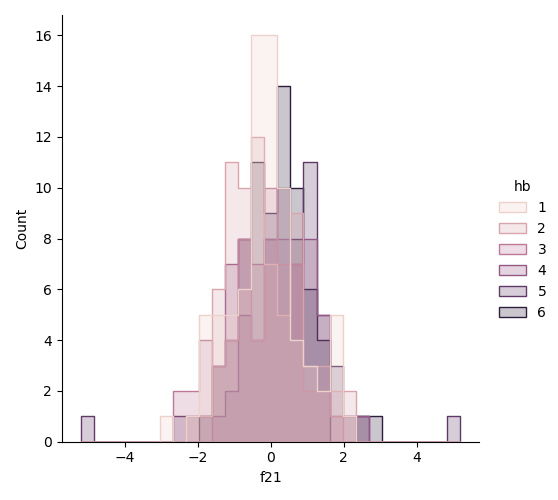

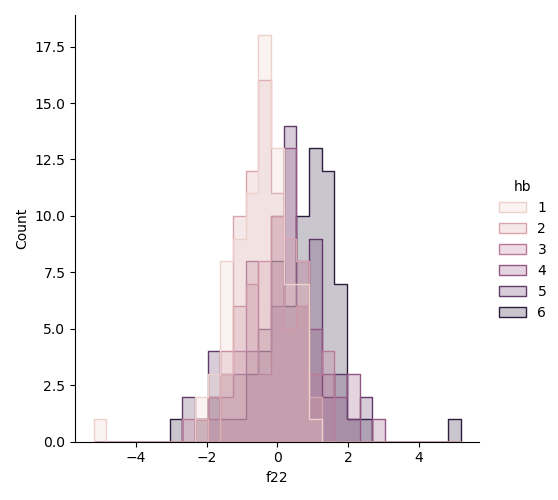

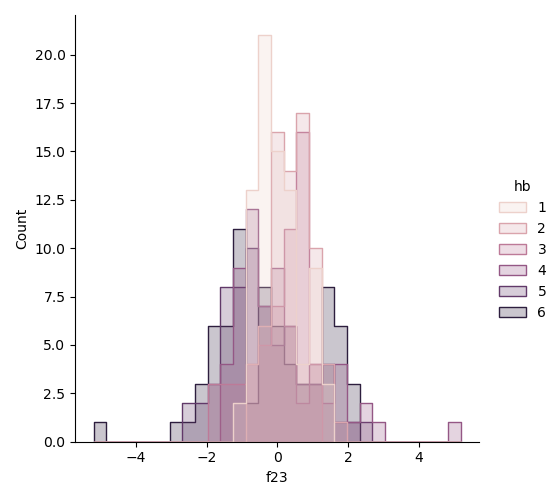

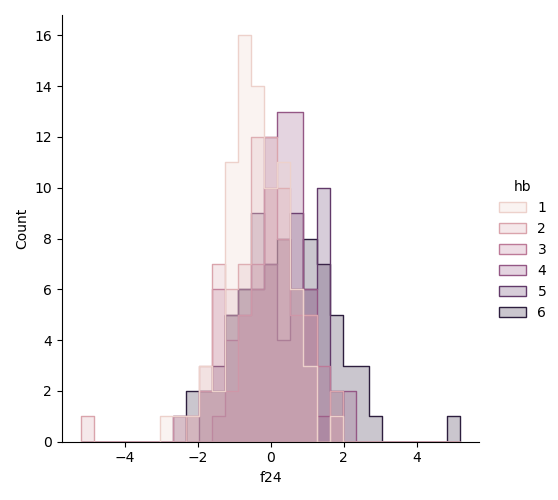

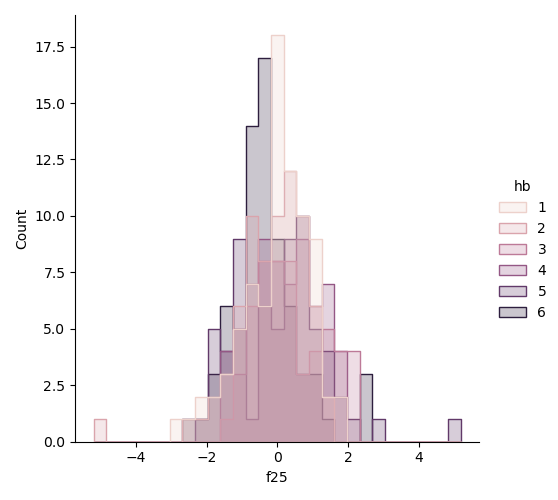

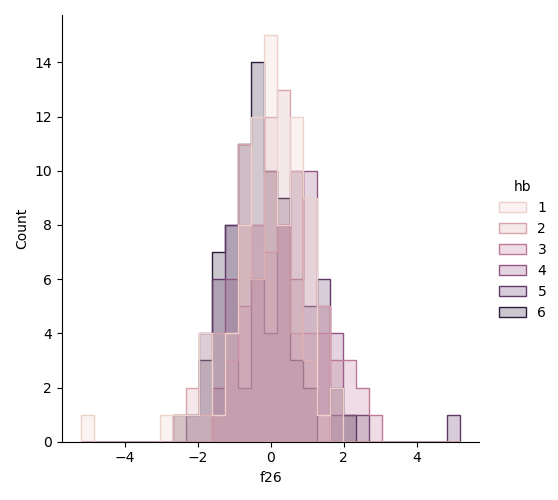

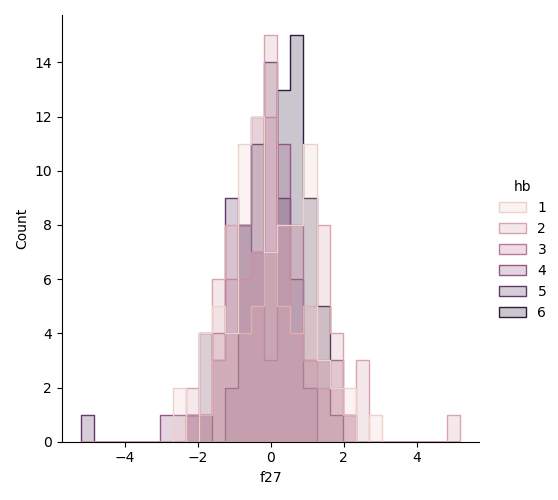

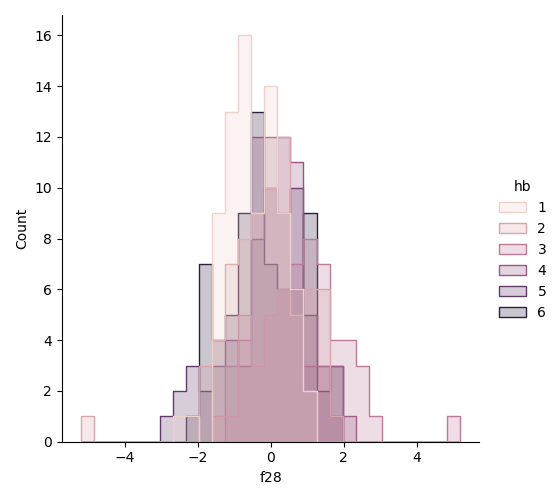

In [17]:
for i in range(0, 29):
    feature_plot(plot_df_scaled, 'f'+str(i), 'hb')